### Efficient Net

$i$番目の畳み込み層を
$$
Y_i=F_i\{X_i\}
$$
と定義します。ここで$F_i$はオペレータ、$Y_i$は出力となります。
また、$X_i$は入力でサイズは$<H_i,W_i,C_i>$となります。$H_i,W_i$は空間方向の次元(幅、高さ),
$C_i$はチャンネル数です。
畳み込みネットワーク$N$は、次のように層の積み重ねで表すことができます。
$$
N=F_k\odot\cdots\odot F_2\odot F_1(X_1)=\odot_{j=1\cdots k}F_j(X_1)
$$
畳み込みネットワークは同じ構造を持った複数のステージに分けられることが多いので、
$$
N=\odot_{i=1\cdots s}F_i^{L_i}(X_{<H_i,W_i,C_i>})
$$
と定義します。$F_i^{L_i}$は$F_i$がステージ$i$では$L_i$回繰り返されることを表します。
ネットワークの長さ(length)$L_i$、チャンネル数(width)$C_i$、解像度(resolution)$(H_i,W_i)$を、モデルの精度を与えられたリソースで最大化するためにスケールすることを考えます。
$$
max_{d,w,r}\ Accuracy(N(d,w,r))\\
s.t.\ N(d,w,r)=\odot_{i=1\cdots s}\hat{F}_i^{d・L_i}(X_{<r・\hat{H}_i,r・\hat{W}_i,w・\hat{C}_i>}　 )\\
Memory(N)\leq target\_memory\\
FLOPS(N)\leq target\_flops
$$
ここで、$w,d,r$はwidth,depth,resolutionのスケーリングの定数です。
また、$\hat{F}_i,\hat{L}_i,\hat{H}_i,\hat{W}_i,\hat{C}_i$はベースラインとなるネットワークで定義されたパラメータとなります。

#### conpound scaling method

それぞれのパラメータのスケーリングは独立していません。
例えば画像の解像度が高い場合は、チャンネル数も増加させなければなりません。
従ってそれぞれのパラメータをバランスよく調整する必要があります。

新しいconpound scaling methodはcompound係数$\phi$を使用して,
width,depth,resolutionを一様にスケールします。
$$
depth:d=\alpha^{\phi}\\
width:w=\beta^{\phi}\\
resolution:r=\gamma^{\phi}\\
s.t.\ \alpha・\beta^2・\gamma^2\approx 2\\
\alpha\geq1,\beta\geq2,\gamma\geq3
$$

ここで、$\alpha,\beta,\gamma$はグリッドサーチなどで決められる定数となります。
今回は、$\alpha・\beta^2・\gamma^2\approx 2$と制限しました。

#### 構造
ベースラインとなるネットワークの構造は次のようになります。
これをEfficientNet-B0と表します。
ここで、MBConvはMobileNetで扱ったmobile inverted bottleneckです。

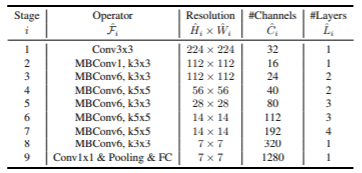

これを起点としてconpound scaling methodを次のように適用します。

EfficientNet-B0($\phi=1$)での最適な$\alpha,\beta,\gamma$は$\alpha=1.2,\beta=1.1,\gamma=1.15$と計算できました。そして、
$$
d=\alpha^{\phi}\\
w=\beta^{\phi}\\
r=\gamma^{\phi}\\
$$
より、算出された$d,w,r$によって、異なる$\phi$でスケールアップされた$B1$から$B7$のネットワークを得ることができます。本来各$\phi$で最適な$\alpha,\beta,\gamma$を計算すべきですが、計算コストなどを考えて固定とします。

#### 学習
最適化手法としてRMSprop、decayは0.9、momentumは0.9です。
weight decayは1e-5とし、学習率は0.256で2.4エポックごとに0.97の減衰率で減少させていきます。

SiLU(Swish-1)を活性化関数として使用しています。
Dropoutの確率はスケールに応じて増加させます。(B0で0.2、B7で0.5)

In [422]:
?RMSprop

In [321]:
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, Activation, Dense, GlobalAveragePooling2D, BatchNormalization, DepthwiseConv2D, Add, Multiply, ReLU, Dropout
from keras.layers.merge import concatenate
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.activations import swish
from tensorflow.keras.callbacks import LearningRateScheduler
import numpy as np
import math
import cv2

In [311]:
def hard_sigmoid(x):
    return ReLU(6.)(x + 3.) * (1. / 6.)

def hard_swish(x):
    return Multiply()([Activation(hard_sigmoid)(x), x])

class SE_Block(Model):
    def __init__(self, in_channels, r=0.25):
        super().__init__()
        self.pool = GlobalAveragePooling2D()
        self.fc1 = Dense(int(in_channels*r))
        self.relu = Activation(hard_sigmoid)
        self.fc2 = Dense(in_channels, activation='sigmoid')
    
    def call(self, x):
        out = self.pool(x)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = Multiply()([x, out])
        return out

In [312]:
class MobileConv(Model):
    def __init__(self, in_channels, out_channels, kernel, t, s, r=0.25):
        super().__init__()
        exp_size = int(t*in_channels)
        
        self.conv1 = Conv2D(filters = exp_size, kernel_size = (1,1), padding = 'same')
        self.bn1 = BatchNormalization()
        self.relu1 = Activation(swish)
    
        self.conv2 = DepthwiseConv2D(kernel_size = kernel, strides=s, padding = 'same')
        self.bn2 = BatchNormalization()
        self.relu2 = Activation(swish)

        self.conv3 = Conv2D(filters = out_channels, kernel_size = (1,1), padding = 'same')
        self.bn3 = BatchNormalization()
        self.relu3 = Activation(swish)
        
        self.se = SE_Block(in_channels=out_channels, r=r)
        
        self.drop = Dropout(rate=0.8,noise_shape=(None, 1, 1, 1))
        self.add = Add()
    
    def call(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu2(out)
        
        out = self.conv3(out)
        out = self.bn3(out)
        out = self.relu3(out)
        
        out = self.se(out)
        
        if K.int_shape(out) == K.int_shape(x):
            out = self.drop(out)
            out = self.add([out, x])
        
        return out

In [316]:
class EfficientNet(Model):
    def __init__(self, d,w,p=0.2):
        super().__init__()    
        self.conv1 = Conv2D(filters = 32, kernel_size = 3, strides=2, padding = 'same')
        self.bn1 = BatchNormalization()
        self.relu1 = Activation(swish)

        self.mbconv1 = self._mobile_conv(in_channels=32,             out_channels=np.ceil(16*w),  kernel=3, L=np.ceil(1*d), t=1, down_sample=False)
        self.mbconv2 = self._mobile_conv(in_channels=np.ceil(16*w),  out_channels=np.ceil(24*w),  kernel=3, L=np.ceil(2*d), t=6, down_sample=True)
        self.mbconv3 = self._mobile_conv(in_channels=np.ceil(24*w),  out_channels=np.ceil(40*w),  kernel=5, L=np.ceil(2*d), t=6, down_sample=True)
        self.mbconv4 = self._mobile_conv(in_channels=np.ceil(40*w),  out_channels=np.ceil(80*w),  kernel=3, L=np.ceil(3*d), t=6, down_sample=True)
        self.mbconv5 = self._mobile_conv(in_channels=np.ceil(80*w),  out_channels=np.ceil(112*w), kernel=5, L=np.ceil(3*d), t=6, down_sample=False)
        self.mbconv6 = self._mobile_conv(in_channels=np.ceil(112*w), out_channels=np.ceil(192*w), kernel=5, L=np.ceil(4*d), t=6, down_sample=True)
        self.mbconv7 = self._mobile_conv(in_channels=np.ceil(192*w), out_channels=np.ceil(320*w), kernel=5, L=np.ceil(1*d), t=6, down_sample=False)
        
        self.conv2 = Conv2D(filters = 1280, kernel_size = 1, strides=1, padding = 'same')
        self.bn2 = BatchNormalization()
        self.relu2 = Activation(swish)
        
        self.pool = GlobalAveragePooling2D()
        self.drop1 = Dropout(p)
        self.fc1 = Dense(1280)
        self.relu3 = Activation(swish)
        self.drop2 = Dropout(p)
        self.fc2 = Dense(10, activation='softmax')
        
    def call(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        
        x = self.mbconv1(x)
        x = self.mbconv2(x)
        x = self.mbconv3(x)
        x = self.mbconv4(x)
        x = self.mbconv5(x)
        x = self.mbconv6(x)
        x = self.mbconv7(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        
        x = self.pool(x)
        x = self.drop1(x)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.drop2(x)
        x = self.fc2(x)
        
        return x
    
    def _mobile_conv(self, in_channels, out_channels, kernel, L, t, down_sample=True):
        mb_layers = []
        for i in range(int(L)):
            s = 1
            if (i==0):
                in_channels=in_channels
                if down_sample:
                    s = 2
            else:
                in_channels = out_channels
                
            mb_layers.append(MobileConv(in_channels=in_channels, out_channels=out_channels, kernel=kernel, t=t, s=s))

        return Sequential(mb_layers)

In [314]:
R={'B0':224, 'B1':240, 'B2':260, 'B3':300, 'B4':380, 'B5':456, 'B6':528, 'B7':600}
D={'B0':1, 'B1':1.1, 'B2':1.2, 'B3':1.4, 'B4':1.8, 'B5':2.2, 'B6':2.6, 'B7':3.1} # L
W={'B0':1, 'B1':1, 'B2':1.1, 'B3':1.2, 'B4':1.4, 'B5':1.6, 'B6':1.8, 'B7':2} #C
P={'B0':0.2, 'B1':0.2, 'B2':0.3, 'B3':0.3, 'B4':0.4, 'B5':0.4, 'B6':0.5, 'B7':0.5}

In [317]:
model_type='B4'

h=R[model_type]

model = EfficientNet(d=D[model_type], w=W[model_type], p=P[model_type])
model.build((None, h, h, 3))  # build with input shape.
dummy_input = Input(shape=(h, h, 3))  # declare without batch demension.
model_summary = Model(inputs=[dummy_input], outputs=model.call(dummy_input))
model_summary.summary()

Model: "functional_129"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_65 (InputLayer)        [(None, 380, 380, 3)]     0         
_________________________________________________________________
conv2d_3943 (Conv2D)         (None, 190, 190, 32)      896       
_________________________________________________________________
batch_normalization_5522 (Ba (None, 190, 190, 32)      128       
_________________________________________________________________
activation_7303 (Activation) (None, 190, 190, 32)      0         
_________________________________________________________________
sequential_411 (Sequential)  (None, 190, 190, 23)      4609      
_________________________________________________________________
sequential_412 (Sequential)  (None, 95, 95, 34)        66756     
_________________________________________________________________
sequential_413 (Sequential)  (None, 48, 48, 56)     

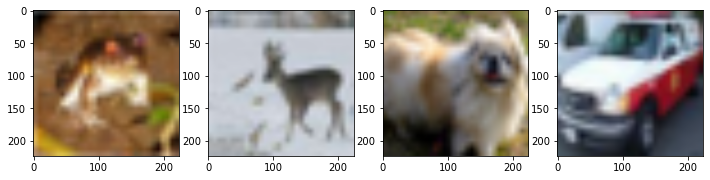

In [368]:
model_type='B0'
h=R[model_type]

# データセットの読み込み
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# バッチサイズ、クラス数、エポック数の設定
batch_size=128
num_classes=10

# データリサイズ
img_rows=h
img_cols=h

x_train = np.array([cv2.resize(img, (img_rows,img_cols)) for img in x_train[::20,:,:,:]])
x_test = np.array([cv2.resize(img, (img_rows,img_cols)) for img in x_test[::20,:,:,:]])

# データ正規化
x_train=x_train.astype('float32')
x_train/=255
x_test=x_test.astype('float32')
x_test/=255

# one-hotベクトル化
y_train = y_train[::20]
y_test = y_test[::20]
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 4, figsize=(12,3))
[axes[i].imshow(x_train[i]) for i in range(4)];

In [318]:
epochs = 100
initial_lrate = 0.256

def decay(epoch, steps=100):
    initial_lrate = 0.256
    drop = 0.97
    epochs_drop = 3
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

sgd = RMSprop(lr=initial_lrate, rho=0.9, epsilon=1.0, decay=0.9)

lr_sc = LearningRateScheduler(decay, verbose=1)

model = EfficientNet(d=D[model_type], w=W[model_type], p=P[model_type])
model.compile(loss=['categorical_crossentropy'], optimizer=sgd, metrics=['accuracy'])

In [322]:
history=model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test), callbacks=[lr_sc])


Epoch 00001: LearningRateScheduler reducing learning rate to 0.256.
Epoch 1/100


KeyboardInterrupt: 

In [421]:
len(y_train)

2500

In [414]:
from tensorflow.keras.applications.efficientnet import EfficientNetB0

input_shape = (224,224,3)

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers[:250]:
    layer.trainable = False

In [398]:
model.summary()

Model: "functional_167"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_84 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_18 (Rescaling)        (None, 224, 224, 3)  0           input_84[0][0]                   
__________________________________________________________________________________________________
normalization_18 (Normalization (None, 224, 224, 3)  7           rescaling_18[0][0]               
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization_18[0][0]           
_____________________________________________________________________________________

__________________________________________________________________________________________________
block2b_se_reduce (Conv2D)      (None, 1, 1, 6)      870         block2b_se_reshape[0][0]         
__________________________________________________________________________________________________
block2b_se_expand (Conv2D)      (None, 1, 1, 144)    1008        block2b_se_reduce[0][0]          
__________________________________________________________________________________________________
block2b_se_excite (Multiply)    (None, 56, 56, 144)  0           block2b_activation[0][0]         
                                                                 block2b_se_expand[0][0]          
__________________________________________________________________________________________________
block2b_project_conv (Conv2D)   (None, 56, 56, 24)   3456        block2b_se_excite[0][0]          
__________________________________________________________________________________________________
block2b_pr

block4a_expand_activation (Acti (None, 28, 28, 240)  0           block4a_expand_bn[0][0]          
__________________________________________________________________________________________________
block4a_dwconv_pad (ZeroPadding (None, 29, 29, 240)  0           block4a_expand_activation[0][0]  
__________________________________________________________________________________________________
block4a_dwconv (DepthwiseConv2D (None, 14, 14, 240)  2160        block4a_dwconv_pad[0][0]         
__________________________________________________________________________________________________
block4a_bn (BatchNormalization) (None, 14, 14, 240)  960         block4a_dwconv[0][0]             
__________________________________________________________________________________________________
block4a_activation (Activation) (None, 14, 14, 240)  0           block4a_bn[0][0]                 
__________________________________________________________________________________________________
block4a_se

block4c_project_bn (BatchNormal (None, 14, 14, 80)   320         block4c_project_conv[0][0]       
__________________________________________________________________________________________________
block4c_drop (Dropout)          (None, 14, 14, 80)   0           block4c_project_bn[0][0]         
__________________________________________________________________________________________________
block4c_add (Add)               (None, 14, 14, 80)   0           block4c_drop[0][0]               
                                                                 block4b_add[0][0]                
__________________________________________________________________________________________________
block5a_expand_conv (Conv2D)    (None, 14, 14, 480)  38400       block4c_add[0][0]                
__________________________________________________________________________________________________
block5a_expand_bn (BatchNormali (None, 14, 14, 480)  1920        block5a_expand_conv[0][0]        
__________

block5c_se_reduce (Conv2D)      (None, 1, 1, 28)     18844       block5c_se_reshape[0][0]         
__________________________________________________________________________________________________
block5c_se_expand (Conv2D)      (None, 1, 1, 672)    19488       block5c_se_reduce[0][0]          
__________________________________________________________________________________________________
block5c_se_excite (Multiply)    (None, 14, 14, 672)  0           block5c_activation[0][0]         
                                                                 block5c_se_expand[0][0]          
__________________________________________________________________________________________________
block5c_project_conv (Conv2D)   (None, 14, 14, 112)  75264       block5c_se_excite[0][0]          
__________________________________________________________________________________________________
block5c_project_bn (BatchNormal (None, 14, 14, 112)  448         block5c_project_conv[0][0]       
__________

__________________________________________________________________________________________________
block6c_dwconv (DepthwiseConv2D (None, 7, 7, 1152)   28800       block6c_expand_activation[0][0]  
__________________________________________________________________________________________________
block6c_bn (BatchNormalization) (None, 7, 7, 1152)   4608        block6c_dwconv[0][0]             
__________________________________________________________________________________________________
block6c_activation (Activation) (None, 7, 7, 1152)   0           block6c_bn[0][0]                 
__________________________________________________________________________________________________
block6c_se_squeeze (GlobalAvera (None, 1152)         0           block6c_activation[0][0]         
__________________________________________________________________________________________________
block6c_se_reshape (Reshape)    (None, 1, 1, 1152)   0           block6c_se_squeeze[0][0]         
__________

block7a_project_conv (Conv2D)   (None, 7, 7, 320)    368640      block7a_se_excite[0][0]          
__________________________________________________________________________________________________
block7a_project_bn (BatchNormal (None, 7, 7, 320)    1280        block7a_project_conv[0][0]       
__________________________________________________________________________________________________
top_conv (Conv2D)               (None, 7, 7, 1280)   409600      block7a_project_bn[0][0]         
__________________________________________________________________________________________________
top_bn (BatchNormalization)     (None, 7, 7, 1280)   5120        top_conv[0][0]                   
__________________________________________________________________________________________________
top_activation (Activation)     (None, 7, 7, 1280)   0           top_bn[0][0]                     
__________________________________________________________________________________________________
global_ave

In [415]:
epochs = 100
initial_lrate = 0.0001

def decay(epoch, steps=100):
    initial_lrate = 0.0001
    drop = 0.97
    epochs_drop = 3
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

sgd = RMSprop(lr=initial_lrate)

lr_sc = LearningRateScheduler(decay, verbose=1)

model.compile(loss=['categorical_crossentropy'], optimizer=keras.optimizers.RMSprop(lr=1e-5), metrics=['accuracy'])

In [416]:
history=model.fit(x_train, y_train, batch_size=128, epochs=epochs, validation_data=(x_test, y_test), validation_steps=int(len(x_test)/64))

Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: 2.3109 - accuracy: 0.10 - ETA: 1:01 - loss: 2.3111 - accuracy: 0.11 - ETA: 1:17 - loss: 2.3088 - accuracy: 0.11 - ETA: 1:21 - loss: 2.3093 - accuracy: 0.10 - ETA: 1:21 - loss: 2.3071 - accuracy: 0.11 - ETA: 1:19 - loss: 2.3098 - accuracy: 0.11 - ETA: 1:16 - loss: 2.3099 - accuracy: 0.11 - ETA: 1:12 - loss: 2.3101 - accuracy: 0.11 - ETA: 1:06 - loss: 2.3096 - accuracy: 0.10 - ETA: 1:01 - loss: 2.3089 - accuracy: 0.10 - ETA: 56s - loss: 2.3091 - accuracy: 0.0994 - ETA: 51s - loss: 2.3096 - accuracy: 0.100 - ETA: 45s - loss: 2.3097 - accuracy: 0.099 - ETA: 39s - loss: 2.3086 - accuracy: 0.102 - ETA: 32s - loss: 2.3079 - accuracy: 0.102 - ETA: 26s - loss: 2.3072 - accuracy: 0.102 - ETA: 19s - loss: 2.3084 - accuracy: 0.101 - ETA: 13s - loss: 2.3083 - accuracy: 0.099 - ETA: 6s - loss: 2.3086 - accuracy: 0.098 - ETA: 0s - loss: 2.3084 - accuracy: 0.0976WARNING:tensorflow:Your input ran out of data; interrupting training. Ma

20/20 [==============================] - 163s 8s/step - loss: 2.3084 - accuracy: 0.0976 - val_loss: 2.3033 - val_accuracy: 0.0940
Epoch 2/100
11/20 [===============>..............] - ETA: 0s - loss: 2.3143 - accuracy: 0.09 - ETA: 1:04 - loss: 2.3122 - accuracy: 0.10 - ETA: 1:20 - loss: 2.3076 - accuracy: 0.11 - ETA: 1:23 - loss: 2.3116 - accuracy: 0.10 - ETA: 1:24 - loss: 2.3095 - accuracy: 0.10 - ETA: 1:22 - loss: 2.3091 - accuracy: 0.10 - ETA: 1:18 - loss: 2.3081 - accuracy: 0.10 - ETA: 1:13 - loss: 2.3086 - accuracy: 0.10 - ETA: 1:09 - loss: 2.3107 - accuracy: 0.10 - ETA: 1:04 - loss: 2.3101 - accuracy: 0.10 - ETA: 59s - loss: 2.3100 - accuracy: 0.1072 

KeyboardInterrupt: 

In [418]:
import gc

gc.collect()

20

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import pytorch_lightning as pl
from torchmetrics import Accuracy as accuracy

In [238]:
class SE_Block(nn.Module):
    def __init__(self, in_channels, r):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc1 = nn.Linear(in_channels, int(in_channels*r))
        self.relu = nn.ReLU(inplace=False)
        self.fc2 = nn.Linear(int(in_channels*r), in_channels)
        self.sigmoid = nn.Hardsigmoid()
    
    def forward(self, x):
        out = self.pool(x)
        out = out.view(out.shape[0], -1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        out = out.view(out.shape[0], out.shape[1], 1,1).expand_as(x)
        return out * x

In [304]:
class MobileConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel, s, t, r=0.25):
        super().__init__()
        exp_size = int(t*in_channels)
        activation = nn.Hardswish
        
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=exp_size, kernel_size = 1)
        self.bn1 = nn.BatchNorm2d(exp_size)
        self.relu1 = activation(False)
    
        self.conv2 = nn.Conv2d(in_channels=exp_size, out_channels=exp_size, kernel_size = kernel, stride=s, groups=exp_size, padding = int((kernel-1)/2))
        self.bn2 = nn.BatchNorm2d(exp_size)
        self.relu2 = activation(False)

        self.conv3 = nn.Conv2d(in_channels=exp_size, out_channels=out_channels, kernel_size = 1)
        self.bn3 = nn.BatchNorm2d(out_channels)
        self.relu3 = activation(False)
        
        self.se = SE_Block(in_channels=out_channels, r=r)
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu2(out)
        
        out = self.conv3(out)
        out = self.bn3(out)
        out = self.relu3(out)
        
        out = self.se(out)

        if out.shape == x.shape:
            out = self.StochasticDepth(out)
            out = out + x
        
        return out
    
    def StochasticDepth(self,x):
        if not self.training:
            return x
        prob = torch.rand((x.shape[0],1,1,1))
        mask = prob < 0.8
        return torch.mul(torch.div(x, 0.8),mask)

In [302]:
class EfficientNet(nn.Module):
    def __init__(self, d, w, p=0.2):
        super().__init__()    
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size = 3, stride=2, padding = 1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.Hardswish(False)

        self.mbconv1 = self._mobile_conv(in_channels=32,             out_channels=np.ceil(16*w),  kernel=3, L=np.ceil(1*d), t=1, down_sample=False)
        self.mbconv2 = self._mobile_conv(in_channels=np.ceil(16*w),  out_channels=np.ceil(24*w),  kernel=3, L=np.ceil(2*d), t=6, down_sample=True)
        self.mbconv3 = self._mobile_conv(in_channels=np.ceil(24*w),  out_channels=np.ceil(40*w),  kernel=5, L=np.ceil(2*d), t=6, down_sample=True)
        self.mbconv4 = self._mobile_conv(in_channels=np.ceil(40*w),  out_channels=np.ceil(80*w),  kernel=3, L=np.ceil(3*d), t=6, down_sample=True)
        self.mbconv5 = self._mobile_conv(in_channels=np.ceil(80*w),  out_channels=np.ceil(112*w), kernel=5, L=np.ceil(3*d), t=6, down_sample=False)
        self.mbconv6 = self._mobile_conv(in_channels=np.ceil(112*w), out_channels=np.ceil(192*w), kernel=5, L=np.ceil(4*d), t=6, down_sample=True)
        self.mbconv7 = self._mobile_conv(in_channels=np.ceil(192*w), out_channels=np.ceil(320*w), kernel=5, L=np.ceil(1*d), t=6, down_sample=False)
        
        self.conv2 = nn.Conv2d(in_channels=int(np.ceil(320*w)), out_channels=1280, kernel_size = 1, stride=1, padding = 0)
        self.bn2 = nn.BatchNorm2d(1280)
        self.relu2 = nn.Hardswish(False)
        
        self.pool = nn.AdaptiveAvgPool2d((1,1))
        self.drop = nn.Dropout(p)
        self.fc = nn.Linear(1280, 1280)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        
        x = self.mbconv1(x)
        x = self.mbconv2(x)
        x = self.mbconv3(x)
        x = self.mbconv4(x)
        x = self.mbconv5(x)
        x = self.mbconv6(x)
        x = self.mbconv7(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        
        x = self.pool(x)
        x = x.view(x.shape[0], -1)
        x = self.drop(x)
        x = self.fc(x)
        
        return x
    
    def _mobile_conv(self, in_channels, out_channels, kernel, L, t, down_sample=True):
        in_channels = int(in_channels)
        out_channels = int(out_channels)
        
        mb_layers = []
        for i in range(int(L)):
            s = 1
            if (i==0):
                in_channels=in_channels
                if down_sample:
                    s = 2
            else:
                in_channels = out_channels
            mb_layers.append(MobileConv(in_channels=in_channels, out_channels=out_channels, kernel=kernel, t=t, s=s))

        return nn.Sequential(*mb_layers)

In [305]:
from torchsummary import summary

R={'B0':224, 'B1':240, 'B2':260, 'B3':300, 'B4':380, 'B5':456, 'B6':528, 'B7':600}
D={'B0':1, 'B1':1.1, 'B2':1.2, 'B3':1.4, 'B4':1.8, 'B5':2.2, 'B6':2.6, 'B7':3.1} # L
W={'B0':1, 'B1':1, 'B2':1.1, 'B3':1.2, 'B4':1.4, 'B5':1.6, 'B6':1.8, 'B7':2} #C
P={'B0':0.2, 'B1':0.2, 'B2':0.3, 'B3':0.3, 'B4':0.4, 'B5':0.4, 'B6':0.5, 'B7':0.5}

model_type='B7'
h=R[model_type]

summary(EfficientNet(d=D[model_type],w=W[model_type]), (3,h,h))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 300, 300]             896
       BatchNorm2d-2         [-1, 32, 300, 300]              64
         Hardswish-3         [-1, 32, 300, 300]               0
            Conv2d-4         [-1, 32, 300, 300]           1,056
       BatchNorm2d-5         [-1, 32, 300, 300]              64
         Hardswish-6         [-1, 32, 300, 300]               0
            Conv2d-7         [-1, 32, 300, 300]             320
       BatchNorm2d-8         [-1, 32, 300, 300]              64
         Hardswish-9         [-1, 32, 300, 300]               0
           Conv2d-10         [-1, 32, 300, 300]           1,056
      BatchNorm2d-11         [-1, 32, 300, 300]              64
        Hardswish-12         [-1, 32, 300, 300]               0
AdaptiveAvgPool2d-13             [-1, 32, 1, 1]               0
           Linear-14                   

AdaptiveAvgPool2d-125             [-1, 48, 1, 1]               0
          Linear-126                   [-1, 12]             588
            ReLU-127                   [-1, 12]               0
          Linear-128                   [-1, 48]             624
     Hardsigmoid-129                   [-1, 48]               0
        SE_Block-130         [-1, 48, 150, 150]               0
      MobileConv-131         [-1, 48, 150, 150]               0
          Conv2d-132        [-1, 288, 150, 150]          14,112
     BatchNorm2d-133        [-1, 288, 150, 150]             576
       Hardswish-134        [-1, 288, 150, 150]               0
          Conv2d-135        [-1, 288, 150, 150]           2,880
     BatchNorm2d-136        [-1, 288, 150, 150]             576
       Hardswish-137        [-1, 288, 150, 150]               0
          Conv2d-138         [-1, 48, 150, 150]          13,872
     BatchNorm2d-139         [-1, 48, 150, 150]              96
       Hardswish-140         [-1, 48, 1

       Hardswish-252           [-1, 80, 75, 75]               0
AdaptiveAvgPool2d-253             [-1, 80, 1, 1]               0
          Linear-254                   [-1, 20]           1,620
            ReLU-255                   [-1, 20]               0
          Linear-256                   [-1, 80]           1,680
     Hardsigmoid-257                   [-1, 80]               0
        SE_Block-258           [-1, 80, 75, 75]               0
      MobileConv-259           [-1, 80, 75, 75]               0
          Conv2d-260          [-1, 480, 75, 75]          38,880
     BatchNorm2d-261          [-1, 480, 75, 75]             960
       Hardswish-262          [-1, 480, 75, 75]               0
          Conv2d-263          [-1, 480, 75, 75]          12,480
     BatchNorm2d-264          [-1, 480, 75, 75]             960
       Hardswish-265          [-1, 480, 75, 75]               0
          Conv2d-266           [-1, 80, 75, 75]          38,480
     BatchNorm2d-267           [-1, 80,

     BatchNorm2d-379          [-1, 160, 38, 38]             320
       Hardswish-380          [-1, 160, 38, 38]               0
AdaptiveAvgPool2d-381            [-1, 160, 1, 1]               0
          Linear-382                   [-1, 40]           6,440
            ReLU-383                   [-1, 40]               0
          Linear-384                  [-1, 160]           6,560
     Hardsigmoid-385                  [-1, 160]               0
        SE_Block-386          [-1, 160, 38, 38]               0
      MobileConv-387          [-1, 160, 38, 38]               0
          Conv2d-388          [-1, 960, 38, 38]         154,560
     BatchNorm2d-389          [-1, 960, 38, 38]           1,920
       Hardswish-390          [-1, 960, 38, 38]               0
          Conv2d-391          [-1, 960, 38, 38]           9,600
     BatchNorm2d-392          [-1, 960, 38, 38]           1,920
       Hardswish-393          [-1, 960, 38, 38]               0
          Conv2d-394          [-1, 160,

          Conv2d-506          [-1, 224, 38, 38]         301,280
     BatchNorm2d-507          [-1, 224, 38, 38]             448
       Hardswish-508          [-1, 224, 38, 38]               0
AdaptiveAvgPool2d-509            [-1, 224, 1, 1]               0
          Linear-510                   [-1, 56]          12,600
            ReLU-511                   [-1, 56]               0
          Linear-512                  [-1, 224]          12,768
     Hardsigmoid-513                  [-1, 224]               0
        SE_Block-514          [-1, 224, 38, 38]               0
      MobileConv-515          [-1, 224, 38, 38]               0
          Conv2d-516         [-1, 1344, 38, 38]         302,400
     BatchNorm2d-517         [-1, 1344, 38, 38]           2,688
       Hardswish-518         [-1, 1344, 38, 38]               0
          Conv2d-519         [-1, 1344, 38, 38]          34,944
     BatchNorm2d-520         [-1, 1344, 38, 38]           2,688
       Hardswish-521         [-1, 1344,

       Hardswish-633         [-1, 2304, 19, 19]               0
          Conv2d-634          [-1, 384, 19, 19]         885,120
     BatchNorm2d-635          [-1, 384, 19, 19]             768
       Hardswish-636          [-1, 384, 19, 19]               0
AdaptiveAvgPool2d-637            [-1, 384, 1, 1]               0
          Linear-638                   [-1, 96]          36,960
            ReLU-639                   [-1, 96]               0
          Linear-640                  [-1, 384]          37,248
     Hardsigmoid-641                  [-1, 384]               0
        SE_Block-642          [-1, 384, 19, 19]               0
      MobileConv-643          [-1, 384, 19, 19]               0
          Conv2d-644         [-1, 2304, 19, 19]         887,040
     BatchNorm2d-645         [-1, 2304, 19, 19]           4,608
       Hardswish-646         [-1, 2304, 19, 19]               0
          Conv2d-647         [-1, 2304, 19, 19]          59,904
     BatchNorm2d-648         [-1, 2304,

     BatchNorm2d-760         [-1, 2304, 19, 19]           4,608
       Hardswish-761         [-1, 2304, 19, 19]               0
          Conv2d-762          [-1, 384, 19, 19]         885,120
     BatchNorm2d-763          [-1, 384, 19, 19]             768
       Hardswish-764          [-1, 384, 19, 19]               0
AdaptiveAvgPool2d-765            [-1, 384, 1, 1]               0
          Linear-766                   [-1, 96]          36,960
            ReLU-767                   [-1, 96]               0
          Linear-768                  [-1, 384]          37,248
     Hardsigmoid-769                  [-1, 384]               0
        SE_Block-770          [-1, 384, 19, 19]               0
      MobileConv-771          [-1, 384, 19, 19]               0
          Conv2d-772         [-1, 2304, 19, 19]         887,040
     BatchNorm2d-773         [-1, 2304, 19, 19]           4,608
       Hardswish-774         [-1, 2304, 19, 19]               0
          Conv2d-775         [-1, 2304,

AdaptiveAvgPool2d-887           [-1, 1280, 1, 1]               0
         Dropout-888                 [-1, 1280]               0
          Linear-889                 [-1, 1280]       1,639,680
Total params: 55,213,728
Trainable params: 55,213,728
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 4.12
Forward/backward pass size (MB): 7221.52
Params size (MB): 210.62
Estimated Total Size (MB): 7436.27
----------------------------------------------------------------


In [ ]:
class EfficientTrainer(pl.LightningModule):
    def __init__(self, model_type='B0'):
        super(VGGTrainer, self).__init__()
        model = EfficientNet(d=D[model_type],w=W[model_type])        
    
    def forward(self, x):
        x = selfEfficientTrainer.model(x)
        return x
    
    def training_step(self, batch, batch_idx):
        x, y = batch 
        #x, y = x.to(device), y.to(device)
        y_hat = self.forward(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        return {'loss': loss, 'y_hat':y_hat, 'y':y, 'batch_loss': loss.item()*x.size(0)}
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        #x, y = x.to(device), y.to(device)
        y_hat = self.forward(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        return {'y_hat':y_hat, 'y':y, 'batch_loss': loss.item()*x.size(0)}
    
    def test_step(self, batch, batch_nb):
        x, y = batch
        #x, y = x.to(device), y.to(device)
        y_hat = self.forward(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        y_label = torch.argmax(y_hat, dim=1)
        acc = accuracy()(y_label, y)
        return {'test_loss': loss, 'test_acc': acc}
    
    def training_epoch_end(self, train_step_output):
        y_hat = torch.cat([val['y_hat'] for val in train_step_outputs], dim=0)
        y = torch.cat([val['y'] for val in train_step_outputs], dim=0)
        epoch_loss = sum([val['batch_loss'] for val in train_step_outputs]) / y_hat.size(0)
        preds = torch.argmax(y_hat, dim=1)
        acc = accuracy()(preds, y)
        self.log('train_loss', epoch_loss, prog_bar=True, on_epoch=True)
        self.log('train_acc', acc, prog_bar=True, on_epoch=True)
        
        print('---------- Current Epoch {} ----------'.format(self.current_epoch + 1))
        print('train Loss: {:.4f} train Acc: {:.4f}'.format(epoch_loass, acc))
    
    def validation_epoch_end(self, val_step_outputs):
        y_hat = torch.cat([val['y_hat'] for val in val_step_outputs], dim=0)
        y = torch.cat([val['y'] for val in val_step_outputs], dim=0)
        epoch_loss = sum([val['batch_loss'] for val in val_step_outputs]) / y_hat.size(0)
        preds = torch.argmax(y_hat, dim=1)
        acc = accuracy()(preds, y)
        self.log('val_loss', epoch_loss, prog_bar=True, on_epoch=True)
        self.log('val_acc', acc, prog_bar=True, on_epoch=True)
        
        print('valid Loss: {:.4f} valid Acc: {:.4f}'.format(epoch_loss, acc))
    
    # New: テストデータに対するエポックごとの処理
    def test_epoch_end(self, test_step_outputs):
        y_hat = torch.cat([val['y_hat'] for val in test_step_outputs], dim=0)
        y = torch.cat([val['y'] for val in test_step_outputs], dim=0)
        epoch_loss = sum([val['batch_loss'] for val in test_step_outputs]) / y_hat.size(0)
        preds = torch.argmax(y_hat, dim=1)
        acc = accuracy()(preds, y)
        self.log('test_loss', epoch_loss, prog_bar=True, on_epoch=True)
        self.log('test_acc', acc, prog_bar=True, on_epoch=True)
        
        print('test Loss: {:.4f} test Acc: {:.4f}'.format(epoch_loss, acc))
        
    def configure_optimizers(self):
        optimizer = optim.RMSprop(self.parameters(), lr=0.1, eps=1.0, momentum=0.9)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.03)
        return {'optimizer': optimizer, 'lr_scheduler': scheduler}

In [ ]:
class EfficientTrainer(pl.LightningModule):
    def __init__(self):
        super(EfficientTrainer, self).__init__()
        efficientb0 = models.efficientnet_b0(pretrained=True)
        
        efficientb0.classifier[1] = nn.Linear(in_features=1280, out_features=10)
        self.model = efficientb0
        
        update_param_names = ['classifier.1.weight', 'classifier.1.bias']
        
        for name, param in self.model.named_parameters():
            if name in update_param_names:
                param.requires_grad = True
            else:
                param.requires_grad = False
        
    def forward(self, x):
        x = self.model(x)
        return x
    
    def training_step(self, batch, batch_idx):
        x, y = batch 
        #x, y = x.to(device), y.to(device)
        y_hat = self.forward(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        return {'loss': loss, 'y_hat':y_hat, 'y':y, 'batch_loss': loss.item()*x.size(0)}
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        #x, y = x.to(device), y.to(device)
        y_hat = self.forward(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        return {'y_hat':y_hat, 'y':y, 'batch_loss': loss.item()*x.size(0)}
    
    def test_step(self, batch, batch_nb):
        x, y = batch
        #x, y = x.to(device), y.to(device)
        y_hat = self.forward(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        y_label = torch.argmax(y_hat, dim=1)
        acc = accuracy()(y_label, y)
        return {'test_loss': loss, 'test_acc': acc}
    
    def training_epoch_end(self, train_step_output):
        y_hat = torch.cat([val['y_hat'] for val in train_step_outputs], dim=0)
        y = torch.cat([val['y'] for val in train_step_outputs], dim=0)
        epoch_loss = sum([val['batch_loss'] for val in train_step_outputs]) / y_hat.size(0)
        preds = torch.argmax(y_hat, dim=1)
        acc = accuracy()(preds, y)
        self.log('train_loss', epoch_loss, prog_bar=True, on_epoch=True)
        self.log('train_acc', acc, prog_bar=True, on_epoch=True)
        
        print('---------- Current Epoch {} ----------'.format(self.current_epoch + 1))
        print('train Loss: {:.4f} train Acc: {:.4f}'.format(epoch_loass, acc))
    
    def validation_epoch_end(self, val_step_outputs):
        y_hat = torch.cat([val['y_hat'] for val in val_step_outputs], dim=0)
        y = torch.cat([val['y'] for val in val_step_outputs], dim=0)
        epoch_loss = sum([val['batch_loss'] for val in val_step_outputs]) / y_hat.size(0)
        preds = torch.argmax(y_hat, dim=1)
        acc = accuracy()(preds, y)
        self.log('val_loss', epoch_loss, prog_bar=True, on_epoch=True)
        self.log('val_acc', acc, prog_bar=True, on_epoch=True)
        
        print('valid Loss: {:.4f} valid Acc: {:.4f}'.format(epoch_loss, acc))
    
    # New: テストデータに対するエポックごとの処理
    def test_epoch_end(self, test_step_outputs):
        y_hat = torch.cat([val['y_hat'] for val in test_step_outputs], dim=0)
        y = torch.cat([val['y'] for val in test_step_outputs], dim=0)
        epoch_loss = sum([val['batch_loss'] for val in test_step_outputs]) / y_hat.size(0)
        preds = torch.argmax(y_hat, dim=1)
        acc = accuracy()(preds, y)
        self.log('test_loss', epoch_loss, prog_bar=True, on_epoch=True)
        self.log('test_acc', acc, prog_bar=True, on_epoch=True)
        
        print('test Loss: {:.4f} test Acc: {:.4f}'.format(epoch_loss, acc))
        
    def configure_optimizers(self):
        optimizer = optim.RMSprop(self.parameters(), lr=0.1, eps=1.0, momentum=0.9)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.01)
        return {'optimizer': optimizer, 'lr_scheduler': scheduler}